# Projet 2 : Préparez des données pour un organisme de santé publique (NB 1: Nettoyage)
  <!-- AUTHOR : Anthony DAVID -->

**Mission :** L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts en prédisant les valeurs manquantes. Notre mission sera de nettoyer et explorer les données puis de prédire les valeurs manquantes et de réaliser des visualisations en vu d'une présentation finale.

**Jeu de données :** Le jeu de données Open Food Facts est disponible sur le [site officiel](https://world.openfoodfacts.org/) (ou disponible à [ce lien](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip) en téléchargement). Les variables sont définies à [cette adresse](https://world.openfoodfacts.org/data/data-fields.txt). Les champs sont séparés en quatre sections :
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

In [1]:
import pandas as pd
from utils import nan_rate_by_columns, count_columns_by_nan_rate, fill_missing_nutriscore, fill_missing_nutrigrade
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.impute import KNNImputer

## Première exploration et nettoyage des données

You can download the data here : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip

In [2]:
df0 = pd.read_csv("data/data.csv", low_memory=False, delimiter='\t')

### Informations sur le dataset

In [3]:
df = df0.copy()
df.shape

(320772, 162)

In [4]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
# Display the head of the DataFrame with all columns
display(df.head())
# Reset display options to the default
pd.reset_option('display.max_columns')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

In [5]:
# Number of columns with more than 50% of NaN values
thresh = 50
count = count_columns_by_nan_rate(df, threshold=thresh)
print(f"Il y a {count} colonnes ayant plus de {thresh}% de valeurs manquantes.")

Il y a 128 colonnes ayant plus de 50% de valeurs manquantes.


Supprimons les colonnes ayant plus de 50% de valeurs manquantes. Cependant, regardions les colonnes **pnns_groups_1** et **pnns_groups_2** car elle contiennent des informations importantes sur les prduits.

In [6]:
# Counting NaN values in 'pnns_group_1' and 'pnns_group_2'
nan_count_pnns_groups_1 = df['pnns_groups_1'].isnull().sum()
nan_count_pnns_groups_2 = df['pnns_groups_2'].isnull().sum()

print(f"Number of NaN values in 'pnns_groups_1': {nan_count_pnns_groups_1}")
print(f"Number of NaN values in 'pnns_groups_2': {nan_count_pnns_groups_2}")

# Printing unique values in 'pnns_groups_1' and 'pnns_groups_2'
unique_values_pnns_groups_1 = df['pnns_groups_1'].unique()
unique_values_pnns_groups_2 = df['pnns_groups_2'].unique()

print("\nUnique values in 'pnns_groups_1':")
print(unique_values_pnns_groups_1)

print("\nUnique values in 'pnns_groups_2':")
print(unique_values_pnns_groups_2)

# Finding similar values
unique_values_pnns_groups_1 = set(unique_values_pnns_groups_1)
unique_values_pnns_groups_2 = set(unique_values_pnns_groups_2)
similar_values = unique_values_pnns_groups_1.intersection(unique_values_pnns_groups_2)

print("\nSimilar values between 'pnns_groups_1' and 'pnns_groups_2':")
print(similar_values)

Number of NaN values in 'pnns_groups_1': 229259
Number of NaN values in 'pnns_groups_2': 226281

Unique values in 'pnns_groups_1':
[nan 'unknown' 'Fruits and vegetables' 'Sugary snacks'
 'Cereals and potatoes' 'Composite foods' 'Fish Meat Eggs' 'Beverages'
 'Fat and sauces' 'fruits-and-vegetables' 'Milk and dairy products'
 'Salty snacks' 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']

Unique values in 'pnns_groups_2':
[nan 'unknown' 'Vegetables' 'Biscuits and cakes' 'Bread' 'Legumes'
 'Pizza pies and quiche' 'Meat' 'Sweets' 'Non-sugared beverages'
 'Sweetened beverages' 'Dressings and sauces' 'One-dish meals'
 'vegetables' 'Soups' 'Chocolate products' 'Alcoholic beverages' 'Fruits'
 'Sandwich' 'Cereals' 'Milk and yogurt' 'Fats' 'Cheese' 'Appetizers'
 'Nuts' 'Breakfast cereals' 'Artificially sweetened beverages'
 'Fruit juices' 'Eggs' 'Fish and seafood' 'Dried fruits' 'Ice cream'
 'Processed meat' 'Potatoes' 'Dairy desserts' 'Fruit nectars' 'pastries'
 'Tripe dishes' 'fruits' '

Comme la colonne pnns_groups_2 est mieux renseignée, c'est celle que nous garderons.

### Suppression des colonnes ayant plus de 50% de valeurs manquantes et inspection des colonnes restantes

In [50]:
df1 = df.copy()
threshold = 0.5 * len(df)
df1 = df1.dropna(axis=1, thresh=threshold)

In [51]:
# Remettons la colonne 'pnns_groups_2' dans df1
column_name_to_add = 'pnns_groups_2'
new_column = df[column_name_to_add]
df1 = pd.concat([df1, new_column], axis=1)

In [52]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     320749 non-null  object 
 1   url                                      320749 non-null  object 
 2   creator                                  320770 non-null  object 
 3   created_t                                320769 non-null  object 
 4   created_datetime                         320763 non-null  object 
 5   last_modified_t                          320772 non-null  object 
 6   last_modified_datetime                   320772 non-null  object 
 7   product_name                             303010 non-null  object 
 8   brands                                   292360 non-null  object 
 9   brands_tags                              292352 non-null  object 
 10  countries                       

In [53]:
# Pourcentage de NaN par colonne
nan_rate_by_columns(df1)

code                                        0.01 %
url                                         0.01 %
creator                                     0.00 %
created_t                                   0.00 %
created_datetime                            0.00 %
last_modified_t                             0.00 %
last_modified_datetime                      0.00 %
product_name                                5.54 %
brands                                      8.86 %
brands_tags                                 8.86 %
countries                                   0.09 %
countries_tags                              0.09 %
countries_fr                                0.09 %
ingredients_text                           22.39 %
serving_size                               34.12 %
additives_n                                22.39 %
additives                                  22.40 %
ingredients_from_palm_oil_n                22.39 %
ingredients_that_may_be_from_palm_oil_n    22.39 %
nutrition_grade_fr             

### Sélection des colonnes relevantes

La mission principale de Santé publique France étant de permettre de connaître la qualité nutritionnelle des produits, concentrons nous sur les colonnes qui apportent une information sur la qualité nutritionnelle. Gardons également le code, la date de creation, le nom du produit, et les pays de distribution.

In [54]:
df1 = df1[['code', 'created_t',\
            'product_name','countries_fr','ingredients_text',\
            'nutrition_grade_fr','energy_100g','fat_100g',\
            'saturated-fat_100g','carbohydrates_100g','sugars_100g',\
            'fiber_100g','proteins_100g','salt_100g',\
            'sodium_100g','nutrition-score-fr_100g', 'pnns_groups_2']]

In [55]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   code                     320749 non-null  object 
 1   created_t                320769 non-null  object 
 2   product_name             303010 non-null  object 
 3   countries_fr             320492 non-null  object 
 4   ingredients_text         248962 non-null  object 
 5   nutrition_grade_fr       221210 non-null  object 
 6   energy_100g              261113 non-null  float64
 7   fat_100g                 243891 non-null  float64
 8   saturated-fat_100g       229554 non-null  float64
 9   carbohydrates_100g       243588 non-null  float64
 10  sugars_100g              244971 non-null  float64
 11  fiber_100g               200886 non-null  float64
 12  proteins_100g            259922 non-null  float64
 13  salt_100g                255510 non-null  float64
 14  sodi

Renommons les colonnes avec des '-' dans leurs nom.

In [56]:
# Rename 'saturated-fat' and 'nutrition-score-fr_100g' for convenience
df1 = df1.rename(columns={"saturated-fat_100g": "saturated_fat_100g", 
                         'nutrition-score-fr_100g': 'nutrition_score_fr_100g'})

**Traitement des doublons**   
Le code-barre est censé être unique, on peut s'en servir comme identifiant.

In [57]:
# Find duplicates in the 'code' column
duplicate_codes = df1[df1.duplicated(subset='code', keep=False)]

# Display the rows with duplicate 'code' values
print("Rows with Duplicate 'code' Values:")
# Set display options to show all columns
pd.set_option('display.max_columns', None)
# Display the head of the DataFrame with all columns
display(duplicate_codes)
# Reset display options to the default
pd.reset_option('display.max_columns')

# Get the unique duplicate 'code' values
unique_duplicate_codes = duplicate_codes['code'].unique()
print("\nUnique Duplicate 'code' Values:")
display(unique_duplicate_codes)

# Count the number of duplicates
print("\nNumber of duplicates:")
display(df1.duplicated(subset=['code']).value_counts())

Rows with Duplicate 'code' Values:


,code,created_t,product_name,countries_fr,ingredients_text,nutrition_grade_fr,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,pnns_groups_2
189068,NaN,France,"Belgique,France",en:whole-milk-yogurts,Yaourts entiers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189103,NaN,"Villecresnes,Villeurbanne,France",France,en:whole-milk-yogurts,Yaourts entiers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137,NaN,NaN,NaN,NaN
189109,NaN,France,"Belgique,France,Suisse",en:whole-milk-yogurts,Yaourts entiers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189119,NaN,"Veynes,France",France,en:stirred-yogurts,Yaourts brassés,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122,NaN,NaN,NaN,NaN
189152,NaN,"Torcy 77,France",France,en:yogurts,Yaourts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158,NaN,NaN,NaN,NaN
189160,NaN,France,France,en:fruit-yogurts,Yaourts aux fruits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156,NaN,NaN,NaN,NaN
189162,NaN,"Saint-Priest,France",France,en:fruit-yogurts,Yaourts aux fruits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158,NaN,NaN,NaN,NaN
189168,NaN,NaN,France,en:stirred-yogurts,Yaourts brassés,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN
189242,NaN,"Villers Bocage 80260,France",France,en:whole-milk-yogurts,Yaourts entiers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189244,NaN,"Villers Bocage 80260,France",France,en:whole-milk-yogurts,Yaourts entiers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Unique Duplicate 'code' Values:


array([nan], dtype=object)


Number of duplicates:


False    320750
True         22
Name: count, dtype: int64

There ara only NaN duplicates. Moreover, almost all numerical entries are NaN, and only 22 duplicates. Let's remove these rows.

In [58]:
df1 = df1.dropna(subset=['code'])

Conversion des timestamps and format date

In [59]:
# Convert timestamps
df1['created_t'] = pd.to_datetime(df1['created_t'], unit='s')

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/2250031796.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df1['created_t'] = pd.to_datetime(df1['created_t'], unit='s')


In [60]:
nan_rate_by_columns(df1)

code                        0.00 %
created_t                   0.00 %
product_name                5.54 %
countries_fr                0.09 %
ingredients_text           22.39 %
nutrition_grade_fr         31.03 %
energy_100g                18.59 %
fat_100g                   23.96 %
saturated_fat_100g         28.43 %
carbohydrates_100g         24.06 %
sugars_100g                23.63 %
fiber_100g                 37.37 %
proteins_100g              18.97 %
salt_100g                  20.34 %
sodium_100g                20.35 %
nutrition_score_fr_100g    31.03 %
pnns_groups_2              70.54 %
dtype: object

<Axes: >

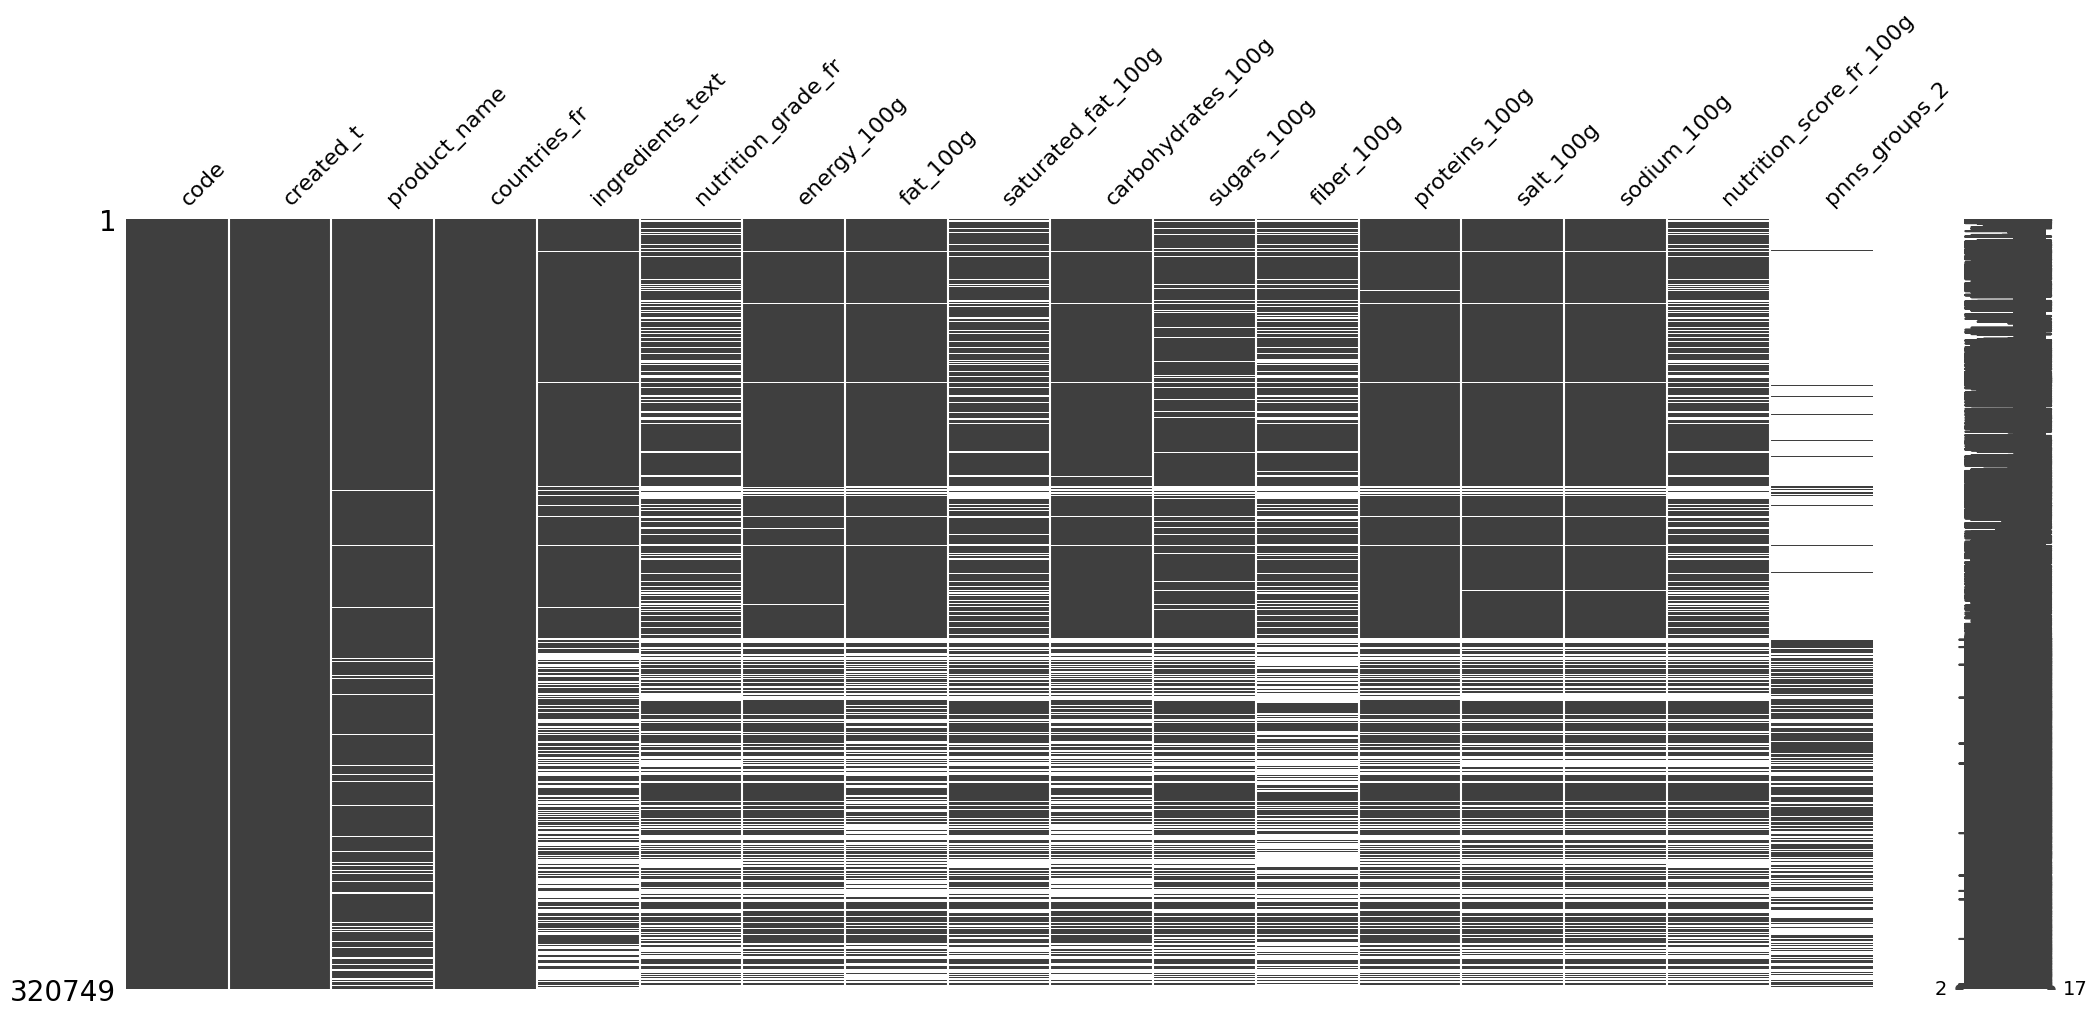

In [61]:
msno.matrix(df1)

Regardons la distribution des valeurs numériques. 

In [17]:
df1.describe()

,created_t,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
count,320749,2.611130e+05,243891.000000,229554.000000,243588.000000,244971.000000,200886.000000,259906.000000,255510.000000,255463.000000,221210.000000
mean,2016-08-08 02:13:23.073804800,1.141915e+03,12.730379,5.129932,32.073981,16.003484,2.862111,7.076366,2.028624,0.798815,9.165535
min,1970-01-01 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-15.000000
25%,2016-05-11 16:21:20,3.770000e+02,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,1.000000
50%,2017-03-09 11:14:08,1.100000e+03,5.000000,1.790000,20.600000,5.710000,1.500000,4.760000,0.581660,0.229000,10.000000
75%,2017-03-09 16:57:36,1.674000e+03,20.000000,7.140000,58.330000,24.000000,3.600000,10.000000,1.374140,0.541000,16.000000
max,2017-04-21 01:14:40,3.251373e+06,714.290000,550.000000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,40.000000
std,NaN,6.447154e+03,17.578747,8.014238,29.731719,22.327284,12.867578,8.409137,128.269454,50.504428,9.055903


Ici 'energy_100g' semble avoir une valeur anormalement élevée. La valeur de 'energy_100g' peut se déterminer par calcul direct en utilisant la formule d'Atwater : energy_100g = fat_100g×37 + carbohydrates_100g×17 + proteins_100g×17 + fiber_100g×8. On voit alors que la valeur maximale permise est 37*100=3700 kJ. Comme cette formule est une version simplifiée de la réalité, plaçons un seuil à 3800 kJ.

In [18]:
df1 = df1[df1['energy_100g']<=3800]

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260756 entries, 1 to 320771
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   code                     260756 non-null  object        
 1   created_t                260756 non-null  datetime64[ns]
 2   product_name             257421 non-null  object        
 3   countries_fr             260687 non-null  object        
 4   ingredients_text         233949 non-null  object        
 5   nutrition_grade_fr       220805 non-null  object        
 6   energy_100g              260756 non-null  float64       
 7   fat_100g                 242497 non-null  float64       
 8   saturated_fat_100g       228817 non-null  float64       
 9   carbohydrates_100g       242622 non-null  float64       
 10  sugars_100g              244443 non-null  float64       
 11  fiber_100g               200323 non-null  float64       
 12  proteins_100g        

Inspectons le taux de rempliqqage

In [20]:
nan_rate_by_columns(df1)

code                        0.00 %
created_t                   0.00 %
product_name                1.28 %
countries_fr                0.03 %
ingredients_text           10.28 %
nutrition_grade_fr         15.32 %
energy_100g                 0.00 %
fat_100g                    7.00 %
saturated_fat_100g         12.25 %
carbohydrates_100g          6.95 %
sugars_100g                 6.26 %
fiber_100g                 23.18 %
proteins_100g               0.64 %
salt_100g                   2.41 %
sodium_100g                 2.42 %
nutrition_score_fr_100g    15.32 %
pnns_groups_2              73.93 %
dtype: object

<Axes: >

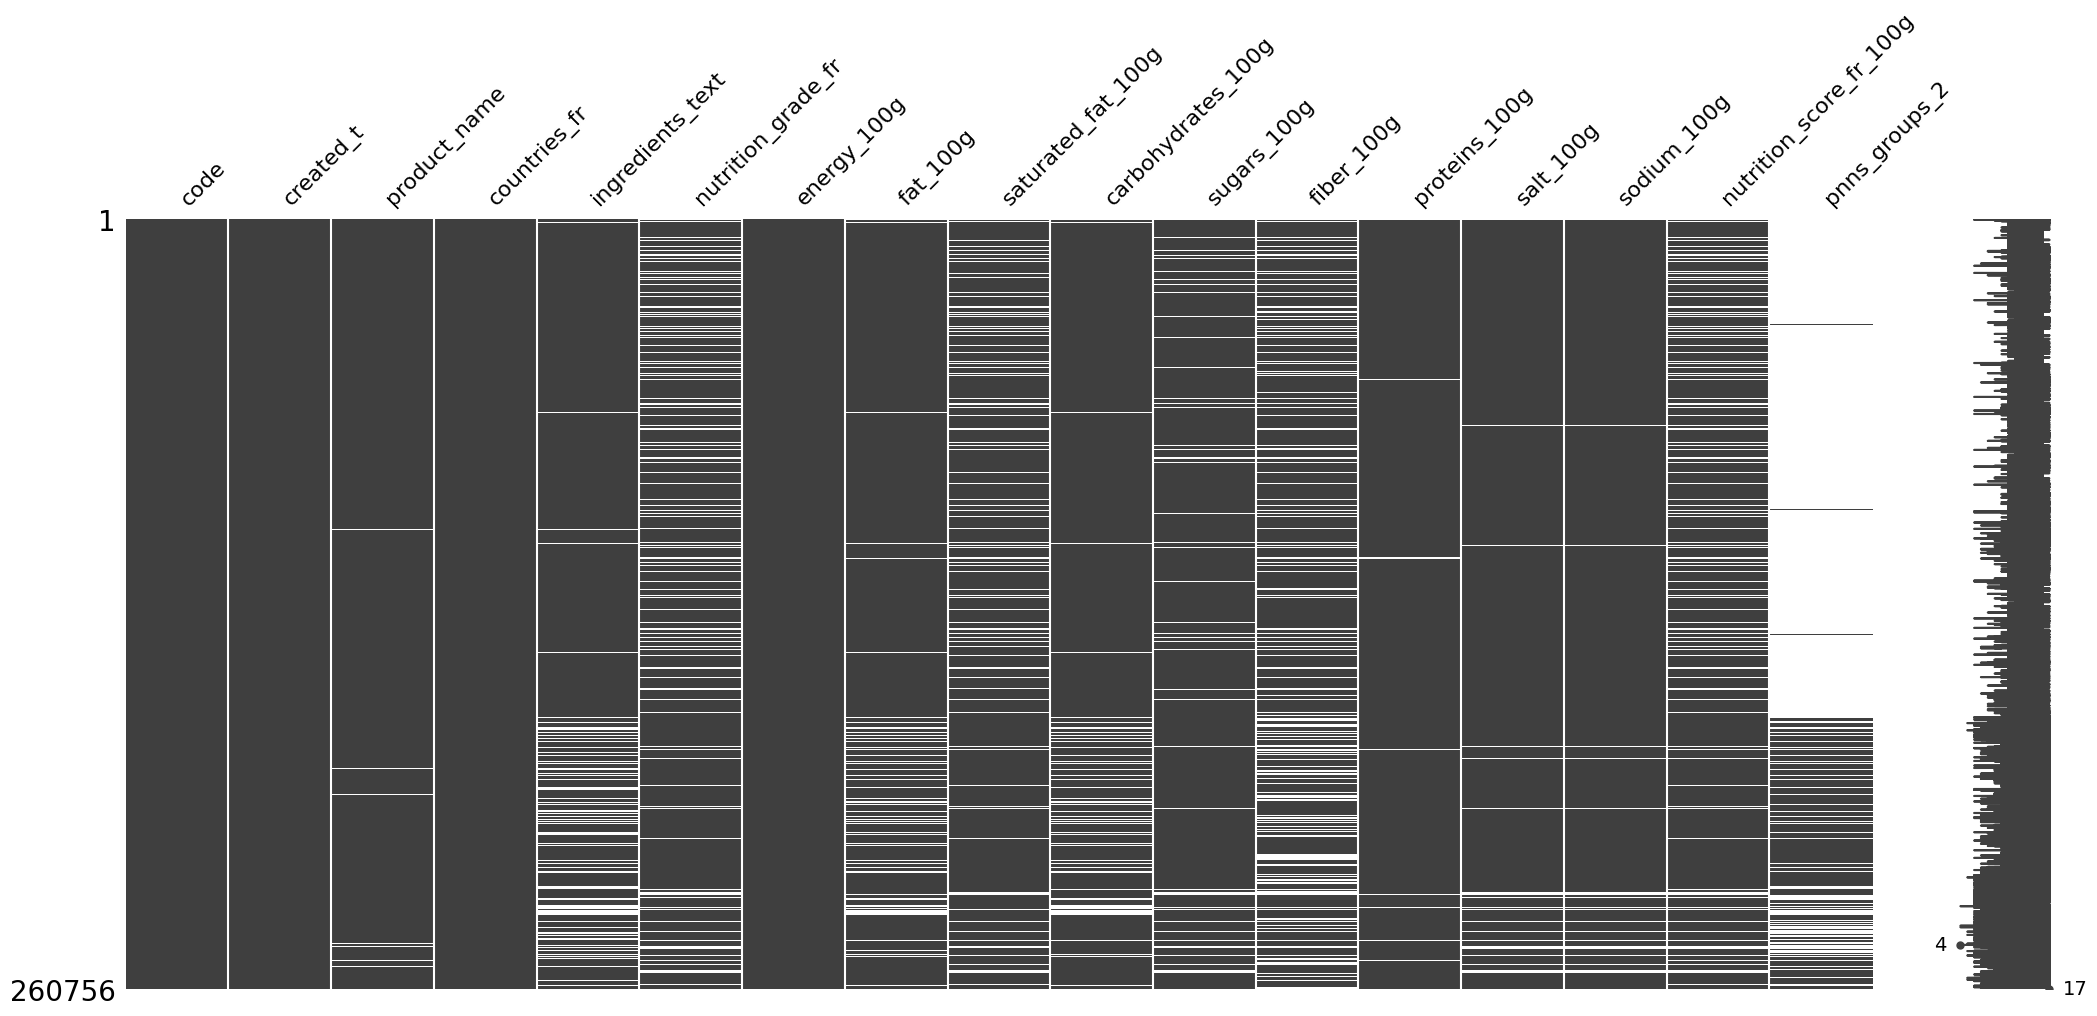

In [21]:
# Visualisation du taux de remplissage
msno.matrix(df1)

### Comblage des valeurs manquantes par calcul direct

Ici nous allons déterminer les valeurs manquantes que nous pouvons obtenir par calcul direct.

Regardons la distribution des valeurs numériques

In [22]:
df2 = df1.copy()
df2.describe()

,created_t,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g
count,260756,260756.000000,242497.000000,228817.000000,242622.000000,244443.000000,200323.000000,259086.000000,254470.000000,254436.000000,220805.000000
mean,2016-09-23 09:38:38.340333056,1121.543927,12.625335,5.097355,32.089066,15.979111,2.833778,7.077202,2.022378,0.796316,9.163678
min,1970-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-15.000000
25%,2017-01-16 01:29:36,375.000000,0.000000,0.000000,6.000000,1.310000,0.000000,0.700000,0.063500,0.025000,1.000000
50%,2017-03-09 13:07:12,1100.000000,5.000000,1.790000,20.710000,5.710000,1.500000,4.760000,0.584200,0.230000,10.000000
75%,2017-03-09 20:28:48,1674.000000,20.000000,7.140000,58.330000,24.000000,3.600000,10.000000,1.379220,0.543000,16.000000
max,2017-04-20 21:13:36,3776.000000,105.000000,100.000000,209.380000,134.000000,178.000000,100.000000,64312.800000,25320.000000,40.000000
std,NaN,792.520980,17.310732,7.811633,29.142008,21.158081,4.615291,8.360375,128.515407,50.599995,9.052334


Comme nous pouvons le voir, les entrées '_100g' ont des valeurs incohérentes qui sont supérieures à 100. Supprimons-les en créant un nouveau jeu de données. De plus, supprimons les ingrédients dont la somme des nutriments est supérieure à 100 (saturated fat est déjà compris dans fat, sugar est déjà dans carbohydrates, et sodium est déjà compté dans sel).

In [23]:
df2 = df2.query('0 <= fat_100g <= 100 \
                and 0 <= saturated_fat_100g <= 100 \
                and 0 <= carbohydrates_100g <= 100 \
                and 0 <= sugars_100g <= 100 \
                and 0 <= fiber_100g <= 100 \
                and 0 <= proteins_100g <= 100 \
                and 0 <= salt_100g <= 100 \
                and 0 <= sodium_100g <= 100 \
                and fat_100g+carbohydrates_100g+fiber_100g+proteins_100g+salt_100g <= 100')

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156068 entries, 12 to 320768
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   code                     156068 non-null  object        
 1   created_t                156068 non-null  datetime64[ns]
 2   product_name             154099 non-null  object        
 3   countries_fr             156050 non-null  object        
 4   ingredients_text         150446 non-null  object        
 5   nutrition_grade_fr       155740 non-null  object        
 6   energy_100g              156068 non-null  float64       
 7   fat_100g                 156068 non-null  float64       
 8   saturated_fat_100g       156068 non-null  float64       
 9   carbohydrates_100g       156068 non-null  float64       
 10  sugars_100g              156068 non-null  float64       
 11  fiber_100g               156068 non-null  float64       
 12  proteins_100g       

In [25]:
nan_rate_by_columns(df2)

code                        0.00 %
created_t                   0.00 %
product_name                1.26 %
countries_fr                0.01 %
ingredients_text            3.60 %
nutrition_grade_fr          0.21 %
energy_100g                 0.00 %
fat_100g                    0.00 %
saturated_fat_100g          0.00 %
carbohydrates_100g          0.00 %
sugars_100g                 0.00 %
fiber_100g                  0.00 %
proteins_100g               0.00 %
salt_100g                   0.00 %
sodium_100g                 0.00 %
nutrition_score_fr_100g     0.21 %
pnns_groups_2              77.03 %
dtype: object

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156068 entries, 12 to 320768
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   code                     156068 non-null  object        
 1   created_t                156068 non-null  datetime64[ns]
 2   product_name             154099 non-null  object        
 3   countries_fr             156050 non-null  object        
 4   ingredients_text         150446 non-null  object        
 5   nutrition_grade_fr       155740 non-null  object        
 6   energy_100g              156068 non-null  float64       
 7   fat_100g                 156068 non-null  float64       
 8   saturated_fat_100g       156068 non-null  float64       
 9   carbohydrates_100g       156068 non-null  float64       
 10  sugars_100g              156068 non-null  float64       
 11  fiber_100g               156068 non-null  float64       
 12  proteins_100g       

Dans les valeurs numériques, seulement la colonne nutriscore ont des valeurs manquantes. Nous allons calculer le nutriscore puis nous pourrons en déduire le nutrigrade.

Avant de combler les valeurs manquantes vérifions que le grade de nutrition est bien composé des 5 classes attendues (a, b, c, d, e)

In [27]:
df2.nutrition_grade_fr.unique()

array(['d', 'a', 'c', 'b', 'e', nan], dtype=object)

Nous avons bien les 5 classes attendues ainsi que des valeurs manquantes que nous allons combler. 

#### Détermination du nutri-score et du nutri-grade

In [28]:
# Prenons une copie de df2
df3 = df2.copy()

Nous pouvons calculer le nutri-score puis le nutri-grade en utilisant la méthode décrite dans l'image ci dessous.

![image](https://www.researchgate.net/profile/Hassan-Aguenaou-2/publication/328136107/figure/fig1/AS:679251904835597@1538957682395/Calcul-de-lalgorithme-du-Nutri-Score-le-score-FRSm-HCSP.ppm)

Pour simplifier nous considérons uniquement les colonnes rouges pour les points A et nous ne nous intéressons pas à la teneur en fruits et légumes de sorte que le nutriscore final N est toujours donné par N = A - C. **Ce résultat pourraît être améliorer en utilisant la formule exacte.**

In [29]:
df3.isnull().sum()

code                            0
created_t                       0
product_name                 1969
countries_fr                   18
ingredients_text             5622
nutrition_grade_fr            328
energy_100g                     0
fat_100g                        0
saturated_fat_100g              0
carbohydrates_100g              0
sugars_100g                     0
fiber_100g                      0
proteins_100g                   0
salt_100g                       0
sodium_100g                     0
nutrition_score_fr_100g       328
pnns_groups_2              120213
dtype: int64

In [30]:
# Apply the custom function to fill missing values in the specified columns
df3['nutrition_score_fr_100g'] = df3.apply(fill_missing_nutriscore, axis=1)
df3['nutrition_grade_fr'] = df3.apply(fill_missing_nutrigrade, axis=1)

In [31]:
nan_rate_by_columns(df3)

code                        0.00 %
created_t                   0.00 %
product_name                1.26 %
countries_fr                0.01 %
ingredients_text            3.60 %
nutrition_grade_fr          0.00 %
energy_100g                 0.00 %
fat_100g                    0.00 %
saturated_fat_100g          0.00 %
carbohydrates_100g          0.00 %
sugars_100g                 0.00 %
fiber_100g                  0.00 %
proteins_100g               0.00 %
salt_100g                   0.00 %
sodium_100g                 0.00 %
nutrition_score_fr_100g     0.00 %
pnns_groups_2              77.03 %
dtype: object

Quelques visualisations

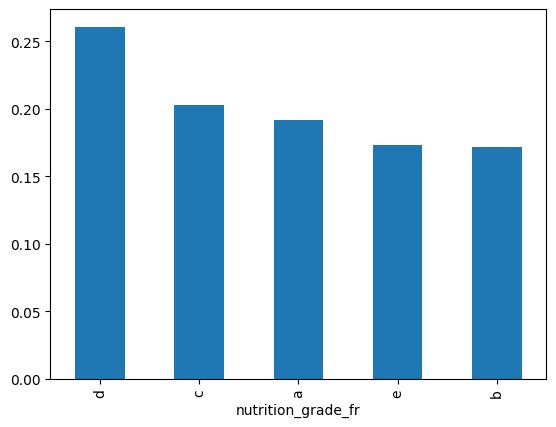

In [32]:
# Diagramme en tuyaux d'orgues
df3["nutrition_grade_fr"].value_counts(normalize=True).plot(kind='bar')
plt.show()

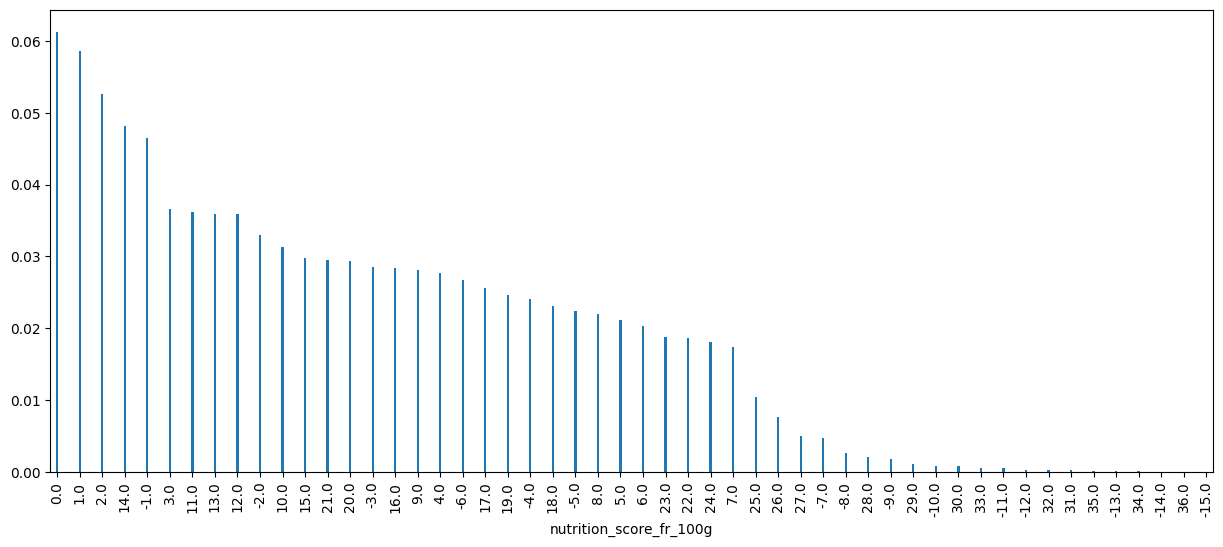

In [33]:
# Diagramme en bâtons
plt.figure(figsize=(15, 6))
df3["nutrition_score_fr_100g"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

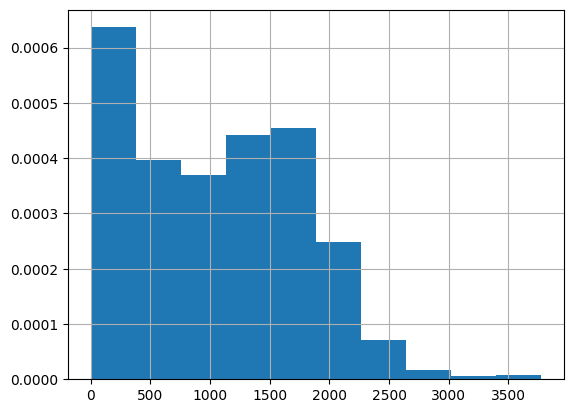

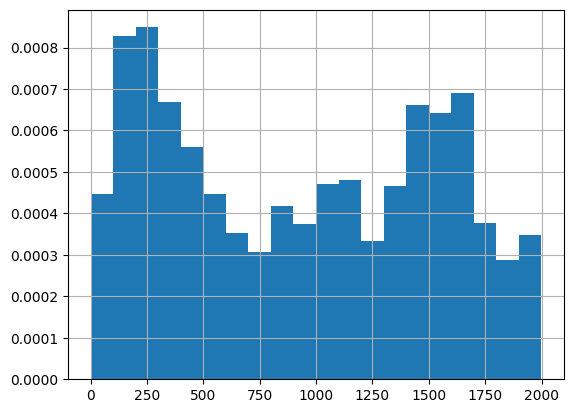

In [34]:
# Histogramme
df3["energy_100g"].hist(density=True)
plt.show()

# Histogramme plus beau
df3[df3.energy_100g.abs() < 2000]["energy_100g"].hist(density=True,bins=20)
plt.show()

### Comblage des valeurs manquantes par KNN Imputing

Reprenons le dataset obtenu avant de combler par calcul direct, puis remplaçons les valeurs que nous avons trouvé.

In [35]:
df4 = df1.copy()
df4.update(df3)

Remplaçons les valeurs des nutriments en dehors de l'interval [0, 100] par NaN. Nous les déterminerons après par KNN imputing. Nous faisons une exception pour les fibres où nous faisons un simple imputing en remplaçant les NaN par zéro car il y a beaucoup de NaN et parce que la pluspart des prduits ont très peu de fibres.

In [36]:
# Assuming column_names is a list of columns to process
column_names = ['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']

# Set values outside the range [0, 100] to NaN
for col in column_names:
    df4[col] = df4[col].mask((df4[col] < 0) | (df4[col] > 100))
    
# Replace null values in 'fiber_100g' with zero
df4['fiber_100g'].fillna(0, inplace=True)

In [37]:
nan_rate_by_columns(df4)

code                        0.00 %
created_t                   0.00 %
product_name                1.28 %
countries_fr                0.03 %
ingredients_text           10.28 %
nutrition_grade_fr         15.20 %
energy_100g                 0.00 %
fat_100g                    7.00 %
saturated_fat_100g         12.25 %
carbohydrates_100g          6.96 %
sugars_100g                 6.26 %
fiber_100g                  0.00 %
proteins_100g               0.64 %
salt_100g                   2.47 %
sodium_100g                 2.44 %
nutrition_score_fr_100g    15.20 %
pnns_groups_2              73.93 %
dtype: object

Faisons un box-plot des nutriments.

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/1459126173.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


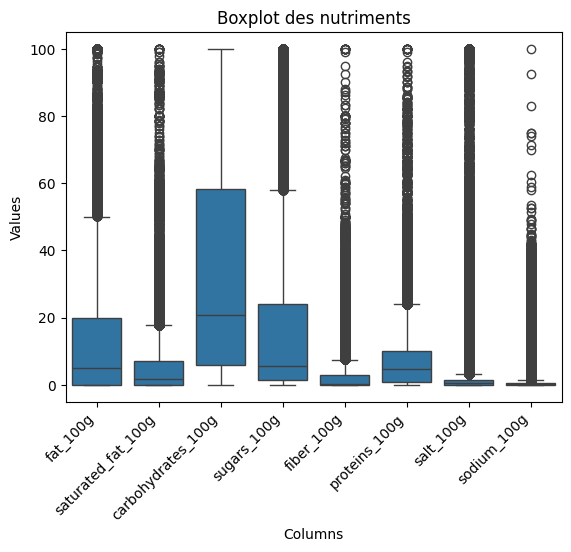

In [38]:
"""
# Create box plot using plotly express
fig = px.box(pd.melt(df4.drop(columns=['code', 'created_t', 'countries_fr', 'ingredients_text', 'nutrition_score_fr_100g', 'energy_100g']),
                     id_vars=['product_name', 'pnns_groups_2', 'nutrition_grade_fr'], var_name='Columns', value_name='Values'),
             x='Columns', y='Values',
             # color='pnns_groups_2',
             labels={'Values': 'Values', 'Columns': 'Columns'},
             title='Boxplot des nutriments',
             # hover_data=['product_name', 'pnns_groups_2', 'nutrition_grade_fr']
             )

# Show the plot
fig.show()
"""

# Create a boxplot using seaborn
ax = sns.boxplot(x='Columns', y='Values', 
                 # hue='pnns_groups_2', 
                 data=pd.melt(df4.drop(columns=['nutrition_grade_fr', 'code', 'created_t', 'countries_fr', 'product_name', 'pnns_groups_2', 
                                                'ingredients_text', 'nutrition_score_fr_100g', 'energy_100g']),
                  # id_vars=['product_name', 'pnns_groups_2'], 
                  var_name='Columns', value_name='Values'))
ax.set(title='Boxplot des nutriments')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#### KNN Imputing

In [62]:
# Create a copy of df4
df5 = df4.copy()

In [63]:
# Specify the columns you want to impute
columns_to_impute = ['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 
                     'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']

# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=5)

# Impute missing values for selected columns
df5[columns_to_impute] = imputer.fit_transform(df5[columns_to_impute])

In [64]:
nan_rate_by_columns(df5)

code                        0.00 %
created_t                   0.00 %
product_name                1.28 %
countries_fr                0.03 %
ingredients_text           10.28 %
nutrition_grade_fr         15.20 %
energy_100g                 0.00 %
fat_100g                    0.00 %
saturated_fat_100g          0.00 %
carbohydrates_100g          0.00 %
sugars_100g                 0.00 %
fiber_100g                  0.00 %
proteins_100g               0.00 %
salt_100g                   0.00 %
sodium_100g                 0.00 %
nutrition_score_fr_100g    15.20 %
pnns_groups_2              73.93 %
dtype: object

<Axes: >

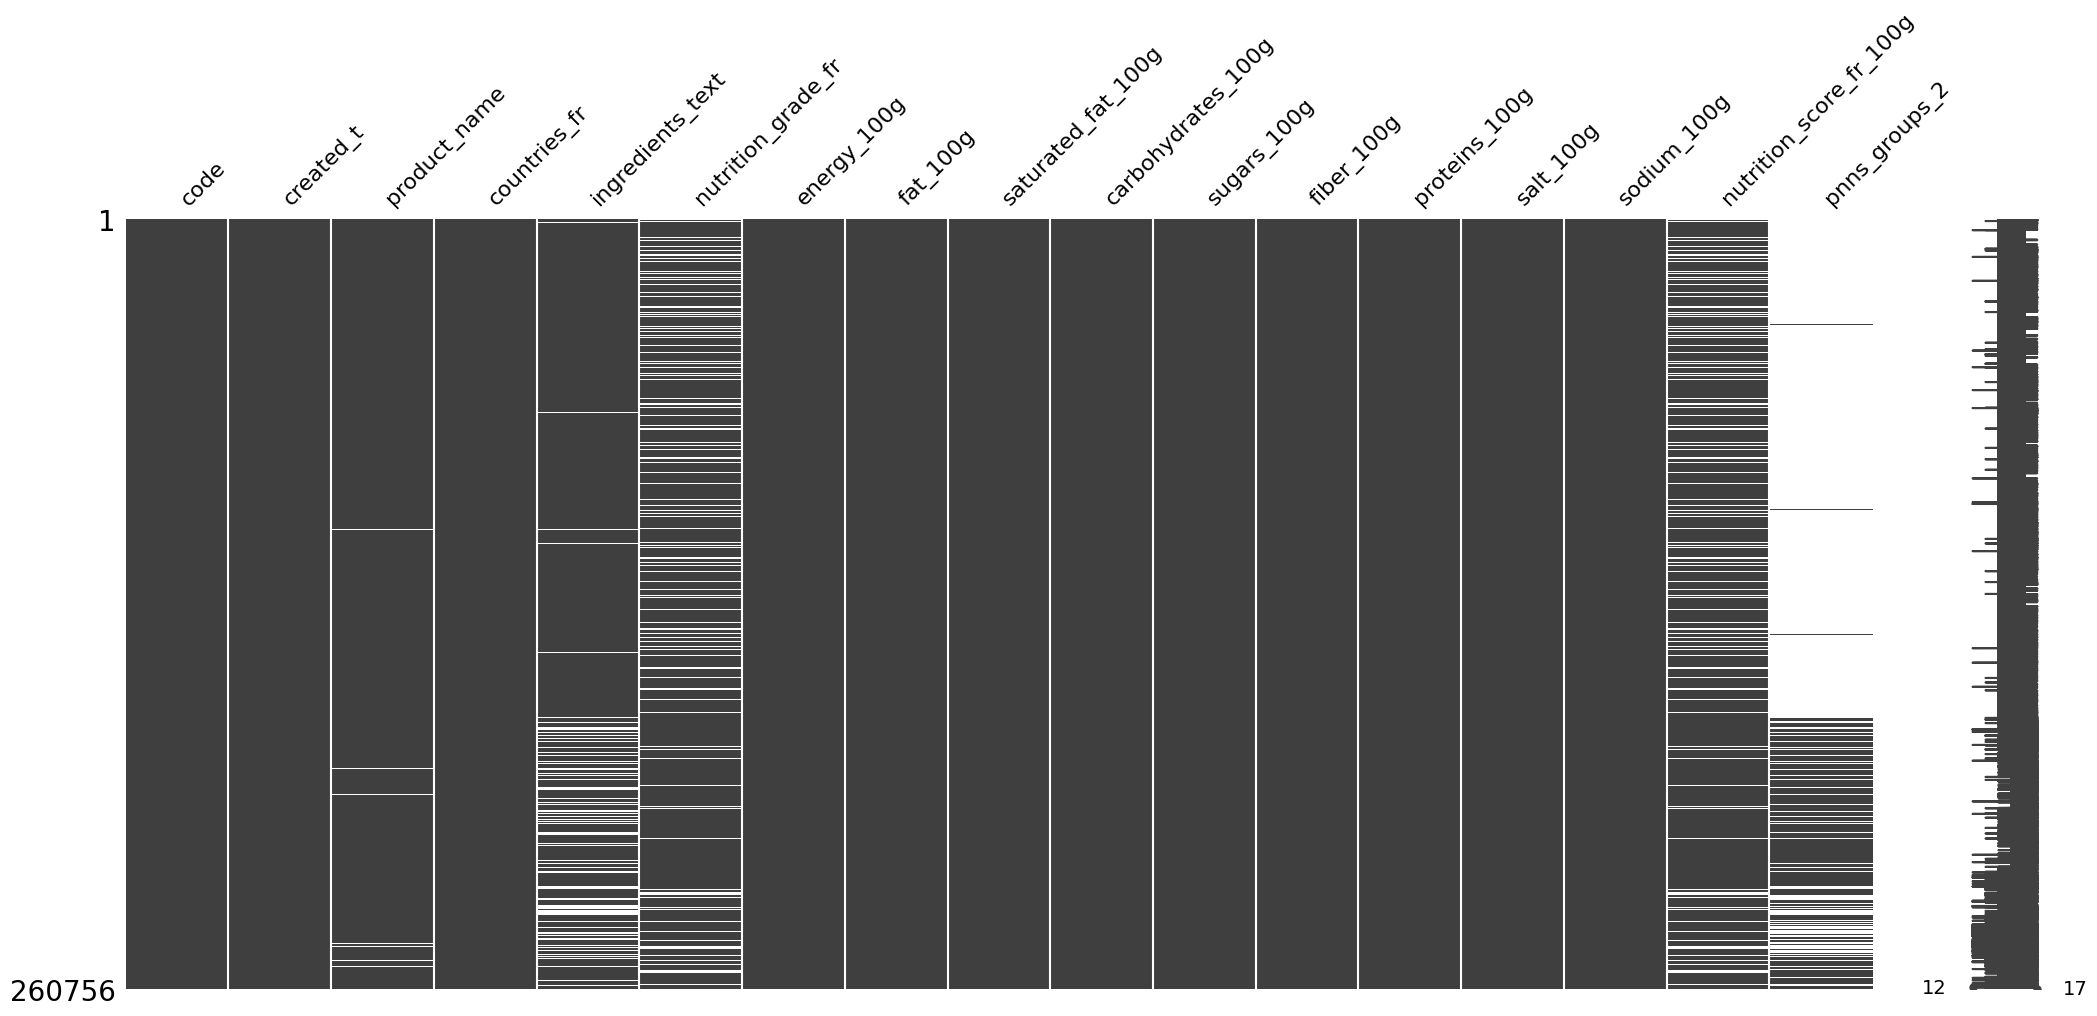

In [65]:
msno.matrix(df5)

In [41]:
# Apply the custom function to fill missing values in the specified columns
df5['nutrition_score_fr_100g'] = df5.apply(fill_missing_nutriscore, axis=1)
df5['nutrition_grade_fr'] = df5.apply(fill_missing_nutrigrade, axis=1)

In [42]:
nan_rate_by_columns(df5)

code                        0.00 %
created_t                   0.00 %
product_name                1.28 %
countries_fr                0.03 %
ingredients_text           10.28 %
nutrition_grade_fr          0.00 %
energy_100g                 0.00 %
fat_100g                    0.00 %
saturated_fat_100g          0.00 %
carbohydrates_100g          0.00 %
sugars_100g                 0.00 %
fiber_100g                  0.00 %
proteins_100g               0.00 %
salt_100g                   0.00 %
sodium_100g                 0.00 %
nutrition_score_fr_100g     0.00 %
pnns_groups_2              73.93 %
dtype: object

<Axes: >

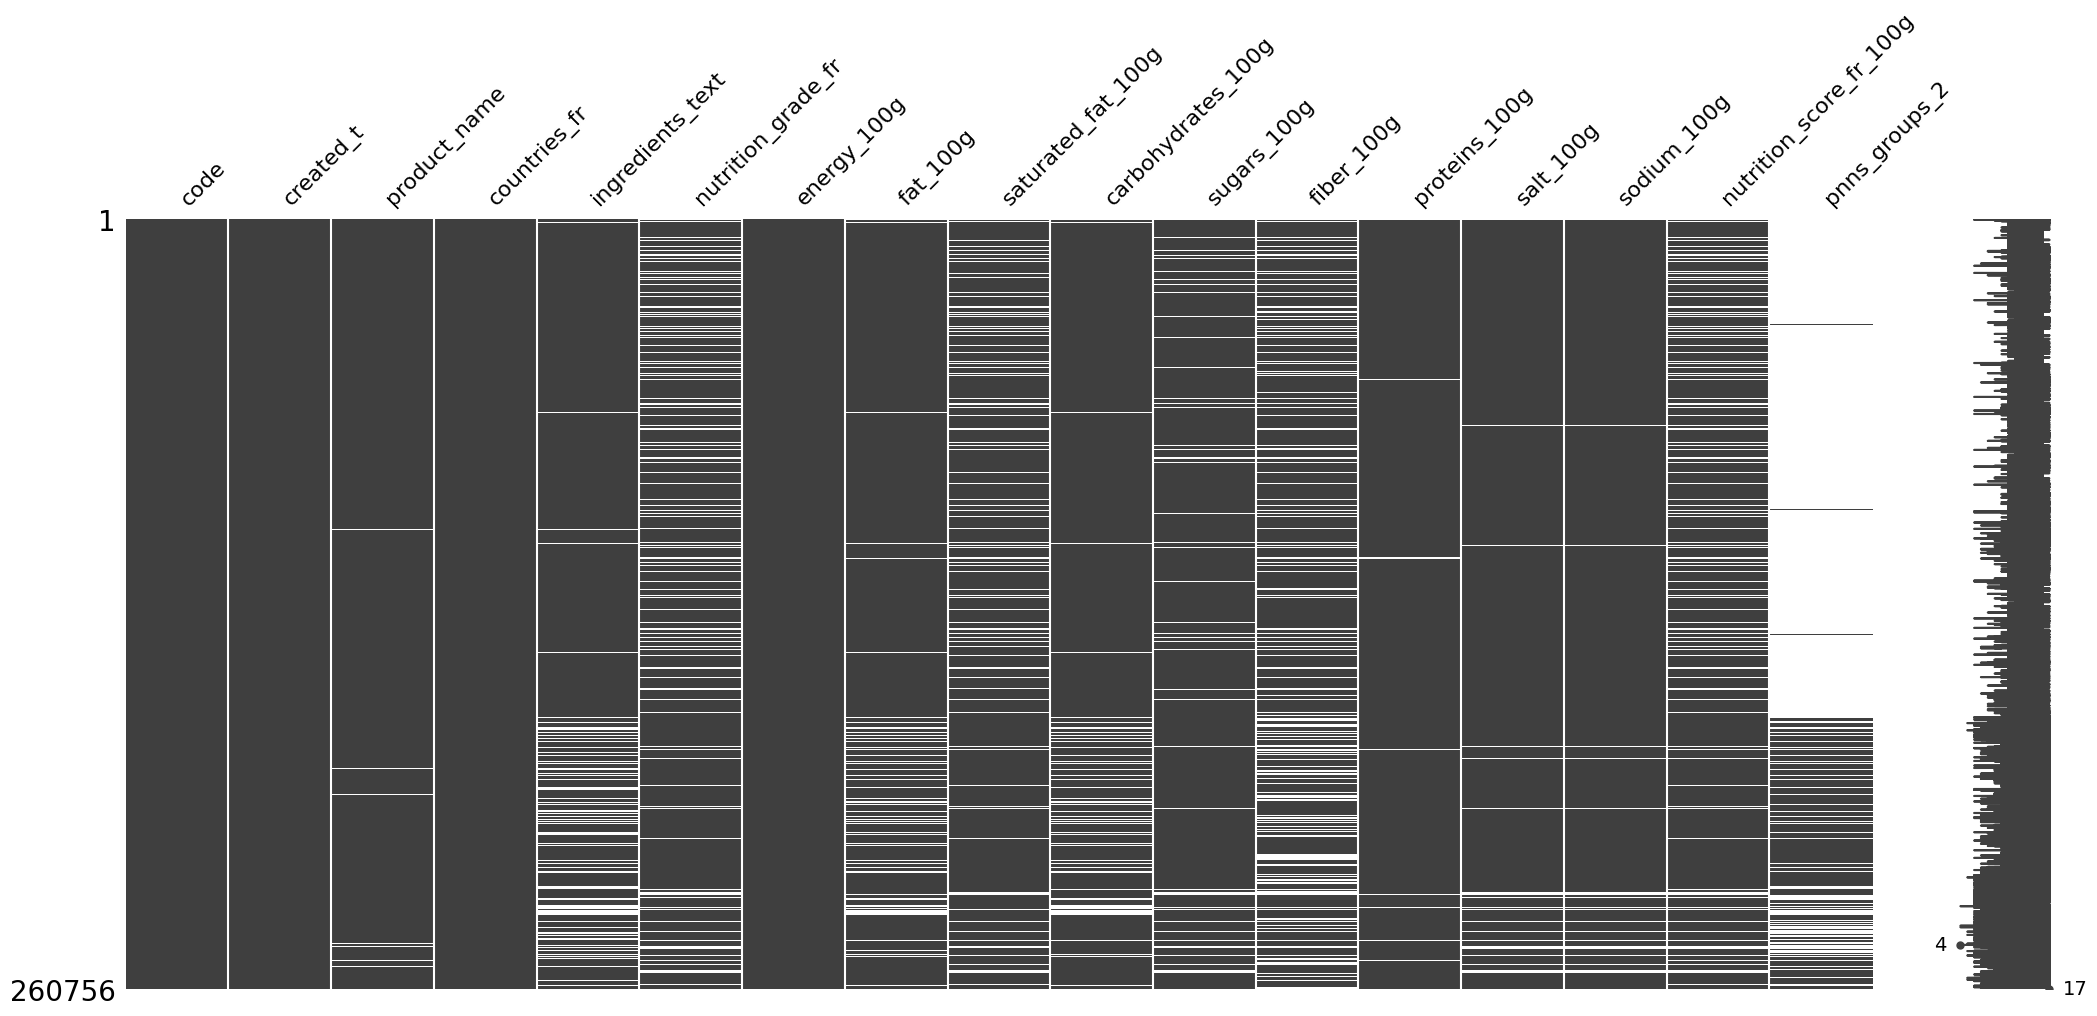

In [43]:
# Visualisation du taux de remplissage
msno.matrix(df1)

<Axes: >

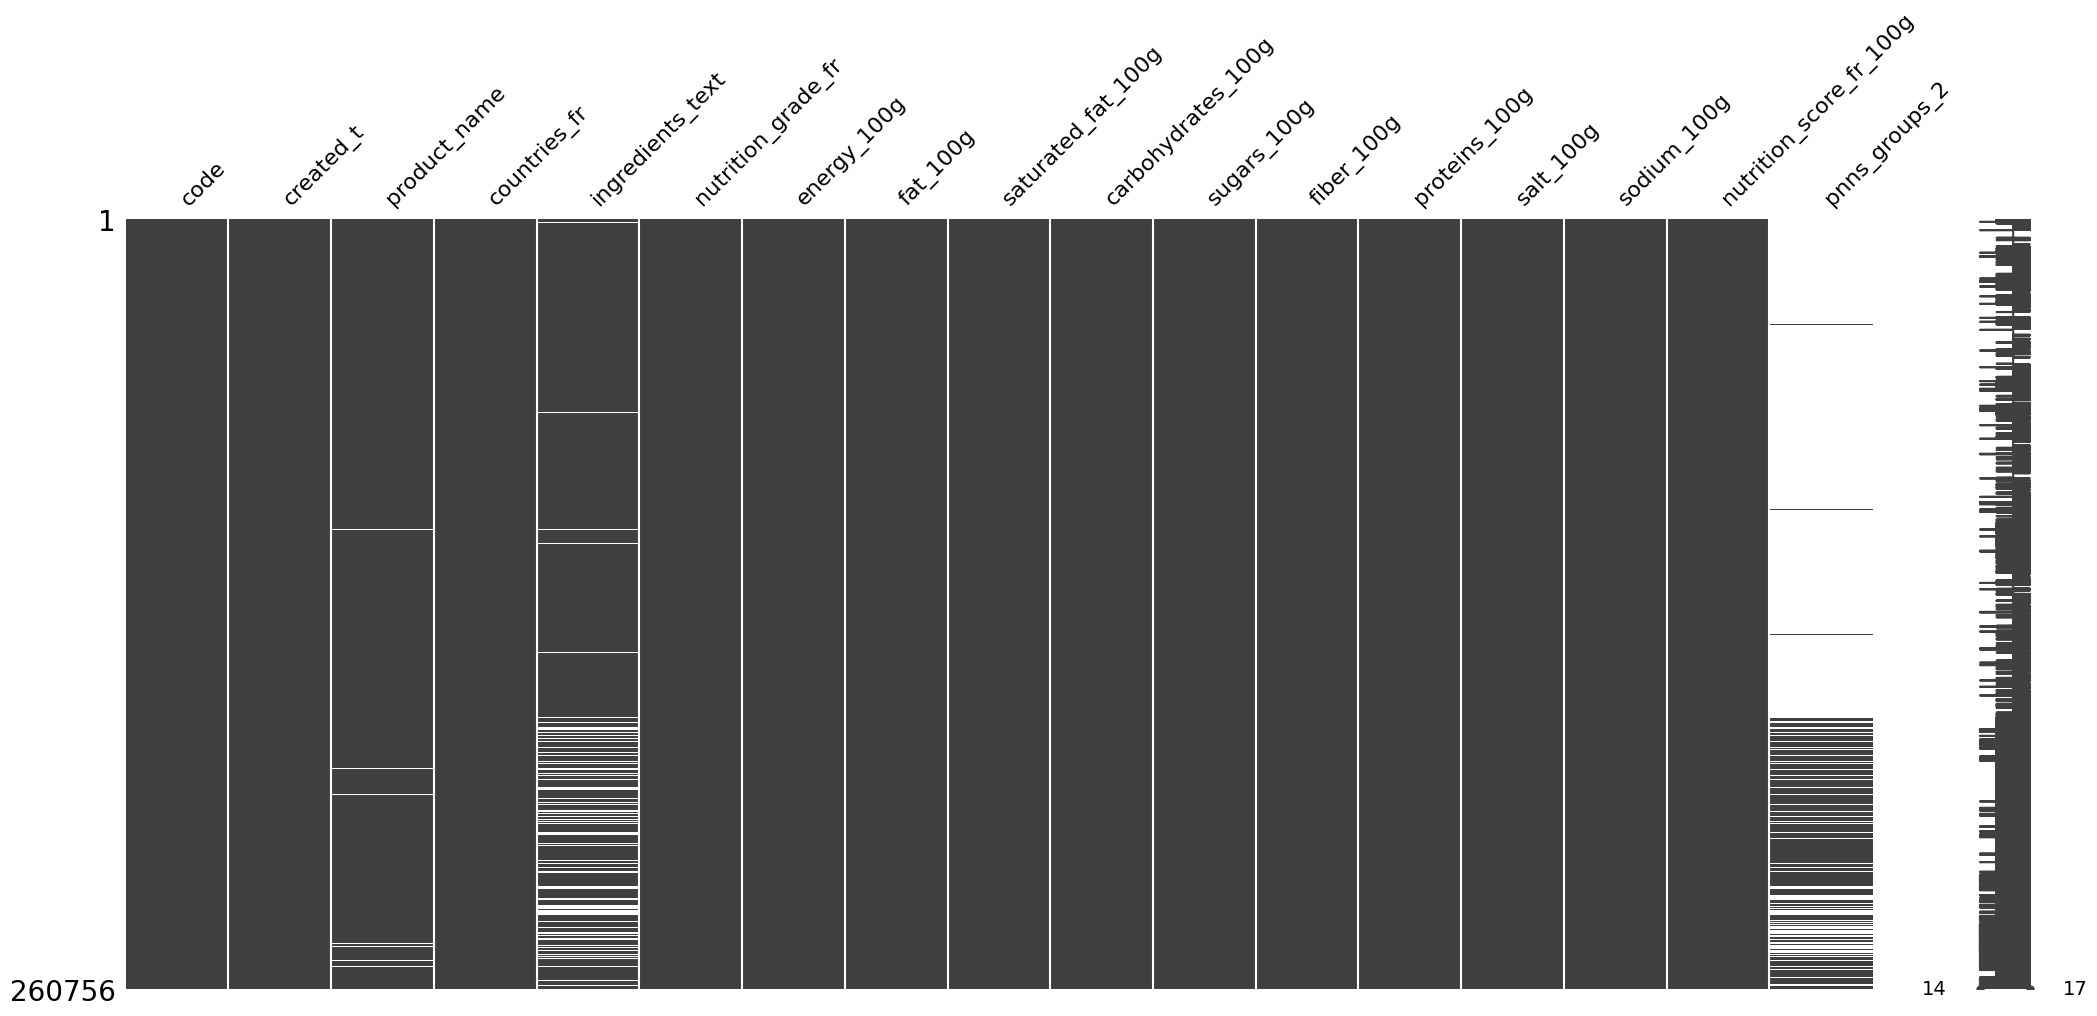

In [44]:
msno.matrix(df5)

In [45]:
df5.to_csv('data/data_cleaned.csv', index=False)

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/1103349007.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


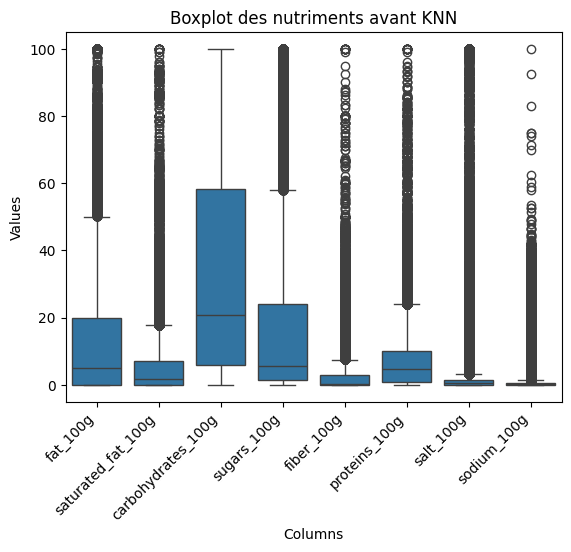

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/1103349007.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


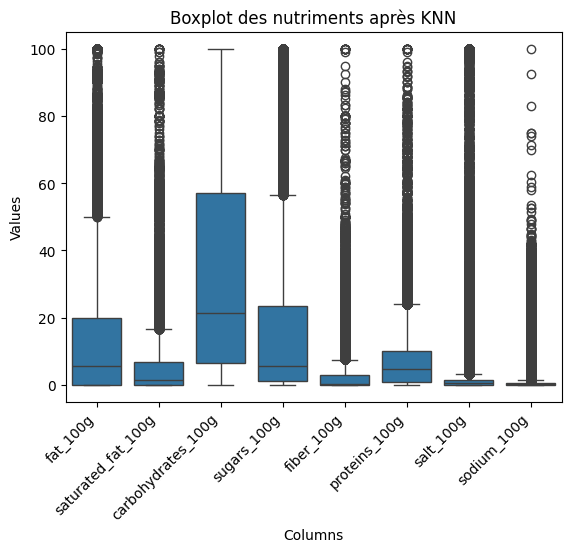

In [46]:
# Create a boxplot using seaborn
ax = sns.boxplot(x='Columns', y='Values', 
                 # hue='pnns_groups_2', 
                 data=pd.melt(df4.drop(columns=['nutrition_grade_fr', 'code', 'created_t', 'countries_fr', 'product_name', 'pnns_groups_2', 
                                                'ingredients_text', 'nutrition_score_fr_100g', 'energy_100g']),
                  # id_vars=['product_name', 'pnns_groups_2'], 
                  var_name='Columns', value_name='Values'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set(title='Boxplot des nutriments avant KNN')
plt.show()

ax = sns.boxplot(x='Columns', y='Values', 
                 # hue='pnns_groups_2', 
                 data=pd.melt(df5.drop(columns=['nutrition_grade_fr', 'code', 'created_t', 'countries_fr', 'product_name', 'pnns_groups_2', 
                                                'ingredients_text', 'nutrition_score_fr_100g', 'energy_100g']),
                  # id_vars=['product_name', 'pnns_groups_2'], 
                  var_name='Columns', value_name='Values'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set(title='Boxplot des nutriments après KNN')
plt.show()

## Nettoyage automatique

In [66]:
import pandas as pd
from utils import fill_missing_nutriscore, fill_missing_nutrigrade
from sklearn.impute import KNNImputer

In [69]:
def data_relevant(df):
    """Cette fonction prend le jeu de données initial en entrée 
    et retourne un jeu de données avec les données pertinentes."""
    # Suppression des colonnes avec +50% de NaN
    df1 = df.dropna(axis=1, thresh=0.5 * len(df))
    # Récupération de la colonne 'pnns_groups_2'
    df1 = pd.concat([df1, df['pnns_groups_2']], axis=1)
    # Gardons les colonnes relevantes pour le nutriscore
    df1 = df1[['code', 'created_t',\
            'product_name','countries_fr','ingredients_text',\
            'nutrition_grade_fr','energy_100g','fat_100g',\
            'saturated-fat_100g','carbohydrates_100g','sugars_100g',\
            'fiber_100g','proteins_100g','salt_100g',\
            'sodium_100g','nutrition-score-fr_100g', 'pnns_groups_2']]
    # Renommons les colonnes qui ont des tirets
    df1 = df1.rename(columns={"saturated-fat_100g": "saturated_fat_100g", 
                         'nutrition-score-fr_100g': 'nutrition_score_fr_100g'})
    # Suppression des lignes ayant NaN comme code-barre
    df1 = df1.dropna(subset=['code'])
    # Conversion des dates
    df1['created_t'] = pd.to_datetime(df1['created_t'], unit='s')
    # Supression des valeurs aberrantes pour l'énergie
    df1 = df1[df1['energy_100g']<=3800]
    return df1


def data_cleaned_by_calculation(df1):
    """Cette fonction prend le jeu de données relevant 
    en entrée et retourne le jeu de données nettoyé par calcul."""
    df2 = df1.copy()
    # Gardons uniquement les données non-NaN qui ne sont pas aberrantes
    df2 = df2.query('0 <= fat_100g <= 100 \
                and 0 <= saturated_fat_100g <= 100 \
                and 0 <= carbohydrates_100g <= 100 \
                and 0 <= sugars_100g <= 100 \
                and 0 <= fiber_100g <= 100 \
                and 0 <= proteins_100g <= 100 \
                and 0 <= salt_100g <= 100 \
                and 0 <= sodium_100g <= 100 \
                and fat_100g+carbohydrates_100g+fiber_100g+proteins_100g+salt_100g <= 100')
    # Calcul du nutriscore et détermination du nutrigrade
    df2['nutrition_score_fr_100g'] = df2.apply(fill_missing_nutriscore, axis=1)
    df2['nutrition_grade_fr'] = df2.apply(fill_missing_nutrigrade, axis=1)
    return df2


def data_cleaned_after_calclulation(df1, df2):
    """Cette fonction prend le jeu de données initial (df1) et 
    le jeu de données nettoyé par calcul (df2) en entrée et 
    retourne le jeu de données complètement nettoyé."""
    # Reprenons df1 et remplaçons les valeurs déterminées dans II
    df3 = df1.copy()
    df3.update(df2) 
    # Assignons NaN aux valeurs aberrantes des nutriments
    column_names = ['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                    'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
    # Set values outside the range [0, 100] to NaN
    for col in column_names:
        df3[col] = df3[col].mask((df3[col] < 0) | (df3[col] > 100))
    # Remplacment des valeurs manquantes en fibre par zéro
    df3['fiber_100g'].fillna(0, inplace=True)
    # KNN Imputing
    columns_to_impute = ['fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 
                     'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
    imputer = KNNImputer(n_neighbors=5)
    df3[columns_to_impute] = imputer.fit_transform(df3[columns_to_impute])
    # Apply the custom function to fill missing values in the specified columns
    df3['nutrition_score_fr_100g'] = df3.apply(fill_missing_nutriscore, axis=1)
    df3['nutrition_grade_fr'] = df3.apply(fill_missing_nutrigrade, axis=1)
    return df3

In [72]:
def preprocessing(df):
    """Cette fonction prend le jeu de données initial en entrée 
    et retourne le jeu de données nettoyé."""
    # I - SELECTIONS DES DONNEES UTILES
    df1 = data_relevant(df)

    ### II - CALCUL DIRECT DU NUTRISCORE
    df2 = data_cleaned_by_calculation(df1)
    
    ### III - CALCUL STATISTIQUE DU NUTRISCORE
    df3 = data_cleaned_after_calclulation(df1, df2)

    # SAVE
    df1.to_csv('data/data_relevant.csv', index=False)
    df2.to_csv('data/data_cleaned_by_calculation.csv', index=False)
    df3.to_csv('data/data_cleaned_auto.csv', index=False)
    
    return df3

In [73]:
%%time
df_original = pd.read_csv("data/data.csv", low_memory=False, delimiter='\t')
df_final = preprocessing(df_original)

/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/2499642428.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df1['created_t'] = pd.to_datetime(df1['created_t'], unit='s')
/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/2499642428.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['nutrition_score_fr_100g'] = df2.apply(fill_missing_nutriscore, axis=1)
/var/folders/17/7v9_fz593_xfss9zy0542f940000gn/T/ipykernel_77403/2499642428.py:43: SettingWithCopyWarni

CPU times: user 23min 27s, sys: 15min 37s, total: 39min 4s
Wall time: 26min 49s


Les Warnings ci dessus ne sont pas importants